In [1]:
# Python libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier as DTC
import seaborn as sns
from sklearn.metrics import log_loss ,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
%matplotlib inline

In [2]:
#reading the CSV file named data_science_task.csv
filename="data_science_task.csv"
data=pd.read_csv(filename)

In [3]:
#explore data
data.info()
#the statistics of the data 
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11998 entries, 0 to 11997
Data columns (total 11 columns):
account_no                     11998 non-null object
gender                         11998 non-null object
age                            11998 non-null int64
income                         11998 non-null int64
loan_amount                    11998 non-null int64
term                           11998 non-null int64
installment_amount             11998 non-null int64
interest_rate                  11998 non-null float64
credit_score_at_application    11998 non-null int64
outstanding_balance            11998 non-null int64
status                         11998 non-null object
dtypes: float64(1), int64(7), object(3)
memory usage: 1.0+ MB


,age,income,loan_amount,term,installment_amount,interest_rate,credit_score_at_application,outstanding_balance
count,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000,11998.000000
mean,33.429655,12711.212702,29262.793799,46.776796,906.091099,0.150078,749.478246,2216.135523
std,9.446930,6054.076749,19022.600570,14.690745,727.649879,0.049614,143.739961,6518.494486
min,18.000000,1507.000000,2000.000000,12.000000,83.000000,-0.040000,500.000000,0.000000
25%,26.000000,7981.000000,15000.000000,36.000000,452.000000,0.120000,630.000000,0.000000
50%,33.000000,11436.000000,24000.000000,48.000000,721.000000,0.150000,750.000000,0.000000
75%,40.000000,16407.500000,39000.000000,60.000000,1136.000000,0.180000,880.000000,0.000000
max,65.000000,49698.000000,116000.000000,72.000000,8430.000000,0.350000,1000.000000,99000.000000


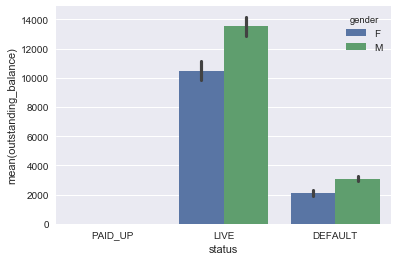

In [4]:
#visualize data
sns.barplot(x="status", y="outstanding_balance",hue="gender", data=data)

In [5]:
#functions to convert characters in numerical values
def target_to_num(x):
    if x=="PAID_UP":
        return 0
    elif x=="DEFAULT":
        return 1
    else:
        return 2

def gender_to_num(x):
    if x=="F":
        return 0
    else:
        return 1

#adding to data, numeric columns for gender and status
data["status_num"]=list(map(target_to_num,data['status']))
data["gender_num"]=list(map(gender_to_num,data['gender']))
del data['status'],data['gender']

#split data into historical data(training) and current data(testing)
test=data[data['status_num']==2]
training=data[data['status_num']!=2]

#assuming that the account_no has no effect on the status we can delete it
del training['account_no'],test['account_no']

#delete columns not need for fitting model
del training['outstanding_balance'],test['outstanding_balance']

#target vectors
y_train=training['status_num']
y_test=test['status_num']

#delete columns not need for fitting model
del training['status_num'],test['status_num']

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    9.7s finished


log loss on Training Data: 0.0290100600238
confusion metrix: [[9278   30]
 [  77  612]]


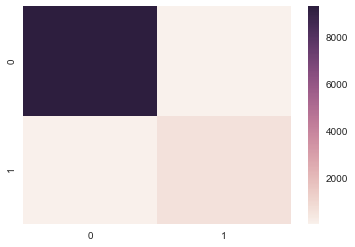

In [7]:
#model selection and fitting
tree=DTC(random_state=0)

#cross validation
cv = ShuffleSplit(n_splits=10,test_size=0.3, random_state=0)

#model variable
algorithms={}
algorithms['Decision Tree']=tree

#function that explore statistics of the data
def get_results():
    results=grid.cv_results_
    min_score=results['mean_test_score'].min()
    max_score=results['mean_test_score'].max()
    std_score=results['std_test_score'].mean()
    return [min_score,max_score,std_score]

    #Decision Tree
tree.get_params()
param_grid=dict(max_features=[None,5,7],max_depth=[3,5,8],presort=[True,False])
grid=GridSearchCV(algorithms['Decision Tree'],param_grid=param_grid,
                  cv=cv,n_jobs=-1,verbose=1)
grid.fit(training,y_train)
best_tree=grid.best_estimator_
best_param_tree=grid.best_params_
best_score_tree=grid.best_score_
results=get_results()

#predict probability of defaulting
tree_pred=pd.DataFrame(best_tree.predict_proba(training))[1]

#cheeking how good is the model using log loss function
print('log loss on Training Data: %s'%log_loss(y_train,tree_pred))

#cheeking how good is the model using confusion matrix
ff=best_tree.predict(training)
kk=confusion_matrix(y_train,ff)
print("confusion metrix: %s"%kk)
sns.heatmap(kk)

In [8]:
#predict probability of not defaulting test data 
y_pred_test=pd.DataFrame(best_tree.predict_proba(test))[0]

#calculate the Expected Book Value in Rands
book_value=data[data['status_num']==2]
book_value['1-POD']=list(y_pred_test)
book_value['expected repayment']=book_value['1-POD']*book_value['outstanding_balance']
print("Expected Book Value:R%s"%sum(book_value['expected repayment']))



Expected Book Value:R23787276.2185


C:\Users\Funny\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Funny\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
